# Deep Q-Networks: MNIST

## Getting Started:

For this notebook, we'll be following along with the PyTorch tutorial created by sentdex: https://pythonprogramming.net/data-deep-learning-neural-network-pytorch/

`torch`: Tensor library similar to NumPy\
`torchvision`: Package from PyTorch with computer vision related datasets, model architectures, and image transformations

# Importing and Preparing Data:

In [1]:
import torch
import torchvision
from torchvision import transforms, datasets

`datasets.MNIST`: Dataset of handwritten numbers. 60,000 samples in the training set, 10,000 samples in the test set.\
`transforms.Compose`: Method that composes multiple transforms together.\
`transforms.ToTensor`: Method that converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0].

In [2]:
train = datasets.MNIST("", train=True, download=True,
                      transform=transforms.Compose([transforms.ToTensor()]))

test = datasets.MNIST("", train=False, download=True,
                      transform=transforms.Compose([transforms.ToTensor()]))

100.1%

Extracting MNIST\raw\train-images-idx3-ubyte.gz to MNIST\raw


113.5%

Extracting MNIST\raw\train-labels-idx1-ubyte.gz to MNIST\raw


100.4%

Extracting MNIST\raw\t10k-images-idx3-ubyte.gz to MNIST\raw


180.4%d:\school\programming\dl_try\dl_venv\lib\site-packages\torchvision\datasets\mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Extracting MNIST\raw\t10k-labels-idx1-ubyte.gz to MNIST\raw
Processing...
Done!


`trainset` - variable to load data into of size 10\
`torch.utils.data.DataLoader` - Dataset and sampler. Provides an interable over the dataset.

`train` - Dataset to iterate over.
`batch_size` - How many samples per batch to load.\
`shuffle` (Boolean) - Randomly shuffle input data to eliminate patterns in original dataset.

In [3]:
trainset = torch.utils.data.DataLoader(train, batch_size=10, shuffle=True)
testset = torch.utils.data.DataLoader(train, batch_size=10, shuffle=False)

In [4]:
for data in trainset:
    print(data)
    break

[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0

`x` (variable) - Features, or **input data**, that we want to predict. Here, it is a tensor of tensors.\
`y` (variable) - Labels, or classification **outputs**, that the neural network is assigning to the input data, `x`.

Sees `x`, calls it `y`.

In [5]:
x, y = data[0][0], data[1][0]

print(y)

tensor(8)


image is 28x28, but data is a 1x28x28

In [6]:
print(data[0][0].shape)

torch.Size([1, 28, 28])


## Scaling/Normalizing, Flattening, and some Visualization

**Scaling/Normalization:** Typically, our data will not all be the same or correct sizes. We want all input data to be in the range of 0 to 1, inclusive, so we have to **scale** the values of each pixel in our data to be in this range.

`data.view(len,height)` is used to reshape our data. Plotting our data as a 1x28x28 will throw an error, so we use `.view(28,28)` to reshape our data as a 28x28 and `plt.imshow()` to visualize our 28x28 image.

**Flatten:** We also have to feed our neural network the data in the form of a vector, so we have to flatten our data from a 1x28x28 into a (1D) vector. We can also do this with `data.view(1,784)`.

Data values of the fourth row of the image are: {tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])}


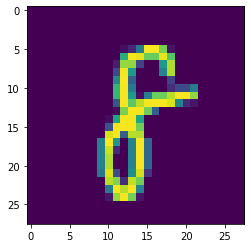

In [7]:
import matplotlib.pyplot as plt

plt.imshow(data[0][0].view(28,28))
print("Data values of the fourth row of the image are:",\
      {data[0][0][0][4]})

We can see that the values equal 0 for the pixels that are not part of the number, and they are equal to a value in the range of (0,1] when the pixel is part of the number. Because these pixel values are in the range of [0,1], rather than typical RGB values (3-tuple/triple of values [0,255]), we know that our data is already scaled!

### Checking for Balance:

**Balancing:** We should make sure that our dataset includes an equal amount of each class. With 60,000 samples and 10 different classes (0-9), we would want 6,000 samples of each number.\
*Otherwise, our classifier would learn that it could be correct a majority of the time by choosing the class with the highest number of samples.*

To figure out how balanced our data is, we can iterate over our dataset and count how many samples of each class we have.

In [8]:
tot = 0
numbers = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0}

for data in trainset:
    xs, ys = data
    for y in ys:
        numbers[int(y)] += 1
        tot += 1
        
print(numbers)

for i in numbers:
    print(f"{i}: {numbers[i]/tot*100.0}%")

{0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}
0: 9.871666666666666%
1: 11.236666666666666%
2: 9.93%
3: 10.218333333333334%
4: 9.736666666666666%
5: 9.035%
6: 9.863333333333333%
7: 10.441666666666666%
8: 9.751666666666667%
9: 9.915000000000001%


It's balanced enough because guessing the same number would give us 11% at best and 9% at worst. If the distribution were greater (like a 30% difference), then we'd have trouble training.

# Creating Neural Network

In [9]:
import torch.nn as nn
import torch.nn.functional as F

`fc1`: Variable for our first fully connected layer. Input is our vector of feature values, which will be a flattened 28p x 28p tensor, i.e. a vector of 784pixels, and our output can be any value we want, but 64 is nice.\
`fc2`, `fc3` and `fc4` inputs are 64 because the size of the output at the layer before it is 64. The output of `fc4` is 10 because there are 10 classes of numbers that it will output.


`nn.Linear`: Fully connected layer. Convolutional layer is `nn.Conv`.

`forward()`: is the method where we define how the data flows through the layers we've defined. The first parameter is `self`, or the class that we've instantiated, and the second parameter is `x`, or the input data.

`F.relu()`: Rectified Linear activation function. Tells us whether the neuron is activated/firing by the value of its output (the second value).

`F.log_softmax(x, dim=1)`: log_softmax is a popular choice to use as the final activation function for a classification network. This normalizes the output `x` into a probability distribution over the output classes `dim=1`. If we used `dim=0`, we'd normalize the data over the batches, rather than the classes.

In [10]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 10)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return F.log_softmax(x, dim=1)
        
net = Net()
print(net)

Net(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
)


We could also implement some logic into the `forward` method to pass the data into the next layer under particular conditions.

For example, consider a neural network trying to learn an optimal control policy for a diabetic patient. If the patient were an adolescent, the data could pass through one set of activation functions, but if the patient were an adult, the data might pass through another set of activation functions.

### Testing the Neural Network with some Random Data

Below, we generate some random input data `x` to simulate a 28x28 pixel image.

In [11]:
x = torch.rand((28,28))

Flatten the data to a (-1, 784), then pass it through the neural network with `net()`.

In [12]:
output = net(x.view(-1,784))
output

tensor([[-2.2810, -2.2865, -2.4614, -2.3590, -2.4126, -2.2243, -2.2084, -2.2526,
         -2.2580, -2.3116]], grad_fn=<LogSoftmaxBackward>)

This output of a tensor within a tensor is the neural network's probability distribution of the random input values `x` over the 10 different characters, and the gradient function used to obtain these output values.

# Training

`loss_f`: Variable defining our loss function. This tells us the error between our targeted output and our neural network's guess. The target outputs will determine our loss function.
- `nn.one_hot`: A class of loss functions. Makes the neural network's guess a scalar and the rest are 0's. For instance, a one_hot vector for inputting a sample of a "3" would read:\
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]

- `nn.CrossEntropyLoss()`: Another class of loss functions.

`optimizer`: Variable for our neural network's optimizer. Tunes model parameters (like weights) to fit the data.
- `optim.Adam()`: Adaptive Momentum optimizer, popular for (???). 
 - `lr()`: The learning rate of our neural network. Determines the magnitude of changes that the optimizer can make at each step, which is proportional to the rate that our model learns. If `lr` too high, it will vary its searches too much and won't improve. If `lr` too low, it might get stuck at a suboptimal solution.
 - Probably need to use a decaying learning rate. Want to learn quickly, but we still want to improve over time.

In [13]:
import torch.optim as optim

loss_f = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

An epoch is one cycle through the full dataset. Too few and our neural network won't fully learn; too many and our neural network will overfit to our "in-sample data", meaning it will perform well with the data it had sampled from, but it won't perform well with data outside of these samples.

In [14]:
for epoch in range(3): #3 passes over data
    for data in trainset: # `data` is a batch of data
        x, y = data # x is batch of features, y is batch of targets
        net.zero_grad() # gradient = 0 before calculating loss
        output = net(x.view(-1,784)) # pass flattened batch through network
        loss = F.nll_loss(output, y) # calculate loss and record it
        loss.backward() # send loss back through network params
        optimizer.step() # tune weights to account for the loss/grad
    print(loss)

tensor(0.2228, grad_fn=<NllLossBackward>)
tensor(0.0217, grad_fn=<NllLossBackward>)
tensor(0.0004, grad_fn=<NllLossBackward>)


In [15]:
correct = 0
total = 0

with torch.no_grad():
    for data in trainset:
        x, y = data
        output = net(x.view(-1,784))
        for idx, i in enumerate(output):
            if torch.argmax(i) == y[idx]:
                correct += 1 #Checking to see if our prediction was correct
            total += 1
            
print("Accuracy: ", round(100*correct/total, 3), "%")

Accuracy:  97.752 %


*This accuracy of >95% is relatively uncommon with real data. Be suspicious if this occurs.

To check out how it's reading:
- We plot the 0th `x[0]` tensor (image) of `x` as a 28x28p image by reshaping it to that size with `view()`.
- We can flatten the image again with `view(-1, 784)` and print the neural network's most confident class prediction using `torch.argmax` on the flattened vector of the 0th `x[0]` tensor (image).

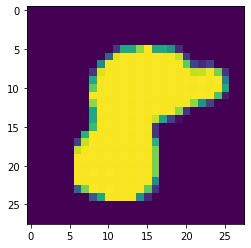

tensor(8)


In [16]:
import matplotlib.pyplot as plt
plt.imshow(x[0].view(28,28))
plt.show()
print(torch.argmax(net(x[0].view(-1,784))))

When I did this, the image depicted a 7 and the network classified it as a 7, so I know it's working. If you did this correctly and the neural network gets it wrong, you're pretty unlucky, because we just saw that this neural network was __% accurate from the previous text. Check the other x's, too (x[4], x[10], ...)

# Convolutional Neural Networks